# ts_for_mushroom_bandit

## Solving the Mushroom Bandit

In this notebook, we'll run an experiment inspired by the paper [Weight Uncertainty in Neural Networks](https://arxiv.org/pdf/1505.05424.pdf) (Blundell et. al, 2015), the Mushroom bandit. In this setting, we use the Mushroom dataset from UCI to simulate a bandit-like game, in order to test some Thompson Sampling-inspired algorithms that try to address the exploration-exploitation tradeoff. Particularly, we will test two interesting ideas:

1. **Bootstrapped Neural Networks:** based on Bootstrapped DQN, a proven method for *deep exploration* in reinforcement learning, presented by [Osband et. al. (2016)](https://arxiv.org/abs/1602.04621). Here, we do not have a full Reinforcement Learning setting, so we call it a Bootstrapped Neural Network, rather than a Bootstrapped DQN.

2. **Sampling from a Random Forest:** let us try to use the individual tree predictions of a Random Forest to build uncertainty estimates for our game. 

We will also test the greedy counterparts of these ideas, a regular neural network and a regular Random Forest.

In [1]:
# plotting inline
%matplotlib inline

# working directory
import os; os.chdir('/home/gdmarmerola/ts_demo')

# importing necessary modules
import random
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, concatenate, Input, Embedding
from keras.layers import Reshape, Merge, Concatenate, BatchNormalization, Dropout
from keras.utils import plot_model

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('bmh')

Using TensorFlow backend.


In [2]:
# setting seeds
random.seed(42)
np.random.seed(42)

## Test with toy data

Let us run our models with simple toy data to check uncertainty estimates first. 

### Generating the data

We will use the formula given by the paper [*Weight Uncertainty in Neural Networks*](https://arxiv.org/pdf/1505.05424.pdf) to generate the data:

$$y = x + 0.3 \cdot{} sin(2π(x + \epsilon)) + 0.3 \cdot{} sin(4 \cdot{} \pi \cdot{}(x + \epsilon)) + \epsilon$$

where $\epsilon \sim \mathcal{N}(0, 0.02)$. Let us generate the data.

In [64]:
# generating examples
#x = np.concatenate([np.random.uniform(0.0, 0.2, 40),np.random.uniform(0.3, 0.5, 40)])
x = np.random.uniform(0.0, 0.5, 100)

# defining the function
noise = sp.stats.norm(0.00, 0.02)
target_toy = lambda x: (x + 0.3*np.sin(2*np.pi*(x + noise.rvs(1)[0])) + 
                        0.3*np.sin(4*np.pi*(x + noise.rvs(1)[0])) + 
                        noise.rvs(1)[0])

# runnning the target
y = np.array([target_toy(e) for e in x])

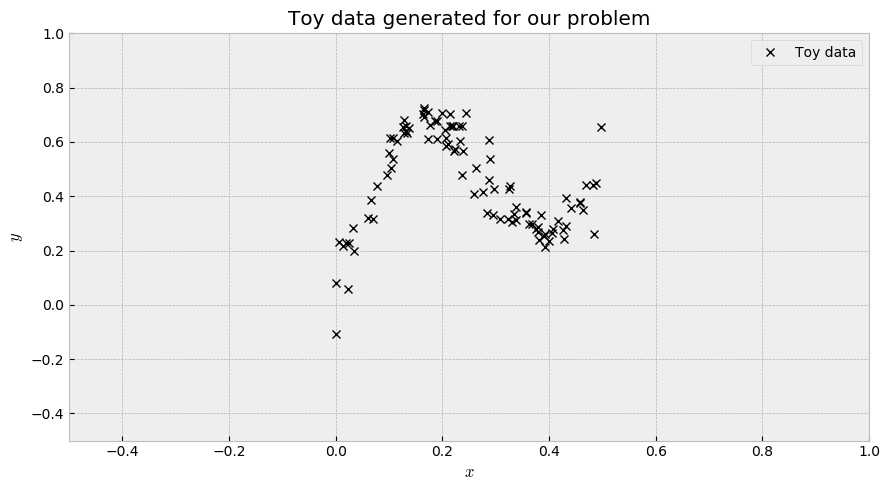

In [66]:
# let us check the toy data
plt.figure(figsize=[9,5], dpi=100)
plt.plot(x, y, 'kx', label='Toy data')
plt.title('Toy data generated for our problem')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5, 1.0);
plt.ylim(-0.5, 1.0);
plt.legend()
plt.tight_layout();
plt.show();

### Random Forest 

Let us start with the simpler model, a Random Forest. What we will try to do is to randomize the forest's output, by sampling sets of decision trees and averaging their predictions.

##### First, let us fit the model

In [67]:
# instance of RF
et = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=2)

In [68]:
# let us fit it to the data
et.fit(x.reshape(-1,1),y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=2, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

##### Now, let us generate predictions for samples of the forest

In [69]:
# let us generate data to check the fit
x_grid = np.linspace(-0.5, 1.0, 200).reshape(-1,1)

In [70]:
# number of samples from the forest
N_SAMPLES = 20

# let us get the predictions of four trees at a time
tree_samples = [np.random.choice(et.estimators_, 4) for i in range(N_SAMPLES)]

In [71]:
# let us predict with these guys
y_grid = np.array([np.array([e.predict(x_grid) for e in np.random.choice(et.estimators_, 2)]).mean(axis=0) for tree_sample in tree_samples])

##### Finally, let us plot the result

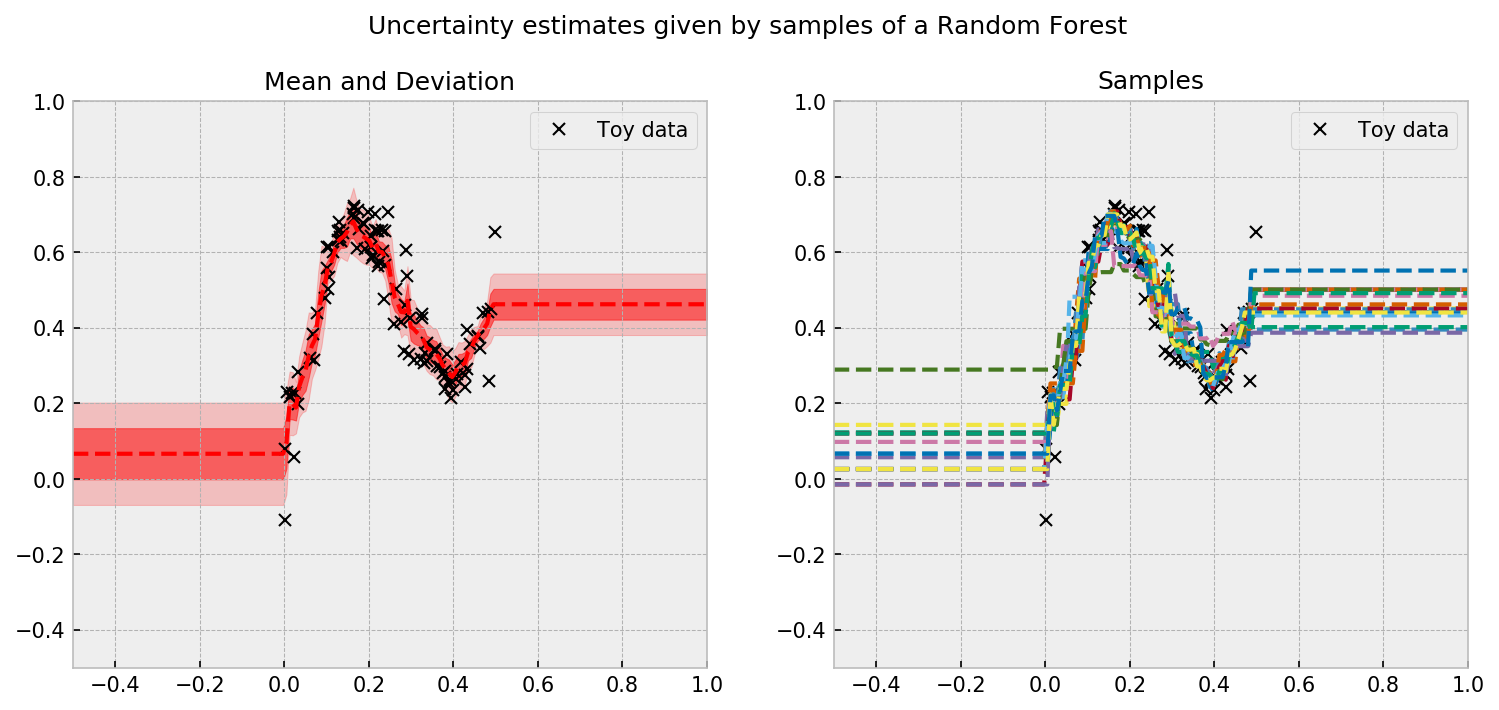

In [72]:
# computing mean and stddev
mean = np.array(y_grid).T.mean(axis=1)
std = np.array(y_grid).T.std(axis=1)

# opening figure
fig = plt.figure(figsize=[12,5], dpi=150)

# title of the plot
fig.suptitle('Uncertainty estimates given by samples of a Random Forest', verticalalignment='center')

# first subplot, 
plt.subplot(1, 2, 1)

# let us plot the training data
plt.plot(x, y, 'kx',  label='Toy data')
plt.title('Mean and Deviation', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-0.5, 1.0)
plt.legend()

# plotting predictive mean and deviation
plt.plot(x_grid, mean, 'r--')
plt.fill_between(x_grid.reshape(1,-1)[0], mean - std, mean + std, alpha=0.5, color='red')
plt.fill_between(x_grid.reshape(1,-1)[0], mean + 2*std, mean - 2*std, alpha=0.2, color='red')

# second subplot
plt.subplot(1, 2, 2)

# let us plot the training data
plt.plot(x, y, 'kx', label='Toy data')
plt.title('Samples', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-0.5, 1.0)
plt.legend()

# loop for plotting predictions of each head 
for i in range(N_SAMPLES):
    plt.plot(x_grid, y_grid[i], linestyle='--')
    
# showing
plt.show();

### Bootstrapped Neural Network

Let us check the uncertainty estimates produced by our Bootstrapped NN. As introduced by [Osband et. al. (2016)](https://arxiv.org/abs/1602.04621), we will train a network with a shared layer and many bootstrapped heads, which will diverge a little bit on their predictions. This divergence will drive efficient exploration and will give us reasonable uncertainty estimates.

##### First, let us build the network's architecture

In [11]:
# defining the model #

# shared network
shared_net = Sequential([Dense(1, activation='linear', input_dim=1), 
                         Dense(16, activation='relu'), 
                         Dense(16, activation='relu'),
                         Dense(16, activation='relu')])


# bootstrap rate and number of heads
BOOTSTRAP_RATE = 1.00
N_HEADS = 10

# initializing lists 
inputs = []
heads = []
x_btrap = []
y_btrap = []

# loop for creating heads and sampled data points
for i in range(N_HEADS):
    
    # deciding sample of data points
    sample_idx = np.random.choice(range(x.shape[0]), int(x.shape[0]*BOOTSTRAP_RATE), True)
    
    # defining the heads in the graph
    input_temp = Input(shape=(1,))
    shared_temp = shared_net(input_temp)
    head_temp = Dense(16, activation='relu')(shared_temp)
    heads.append(Dense(1, activation='linear')(head_temp))
    inputs.append(input_temp)
    
    # defining data
    x_btrap.append(x[sample_idx])
    y_btrap.append(y[sample_idx])
    
# defining the model and plotting it
model = Model(inputs=inputs, outputs=heads)
plot_model(model)

# compiling
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

##### Let us now fit the model and simulate predictions for each of the bootstrapped heads

In [12]:
# fitting the model
model.fit(x_btrap, y_btrap, epochs=500, batch_size=64, verbose=0);

In [13]:
# let us check the fit
x_grid = np.linspace(-0.5, 1.0, 200).reshape(-1,1)
y_grid = model.predict([x_grid] * N_HEADS)

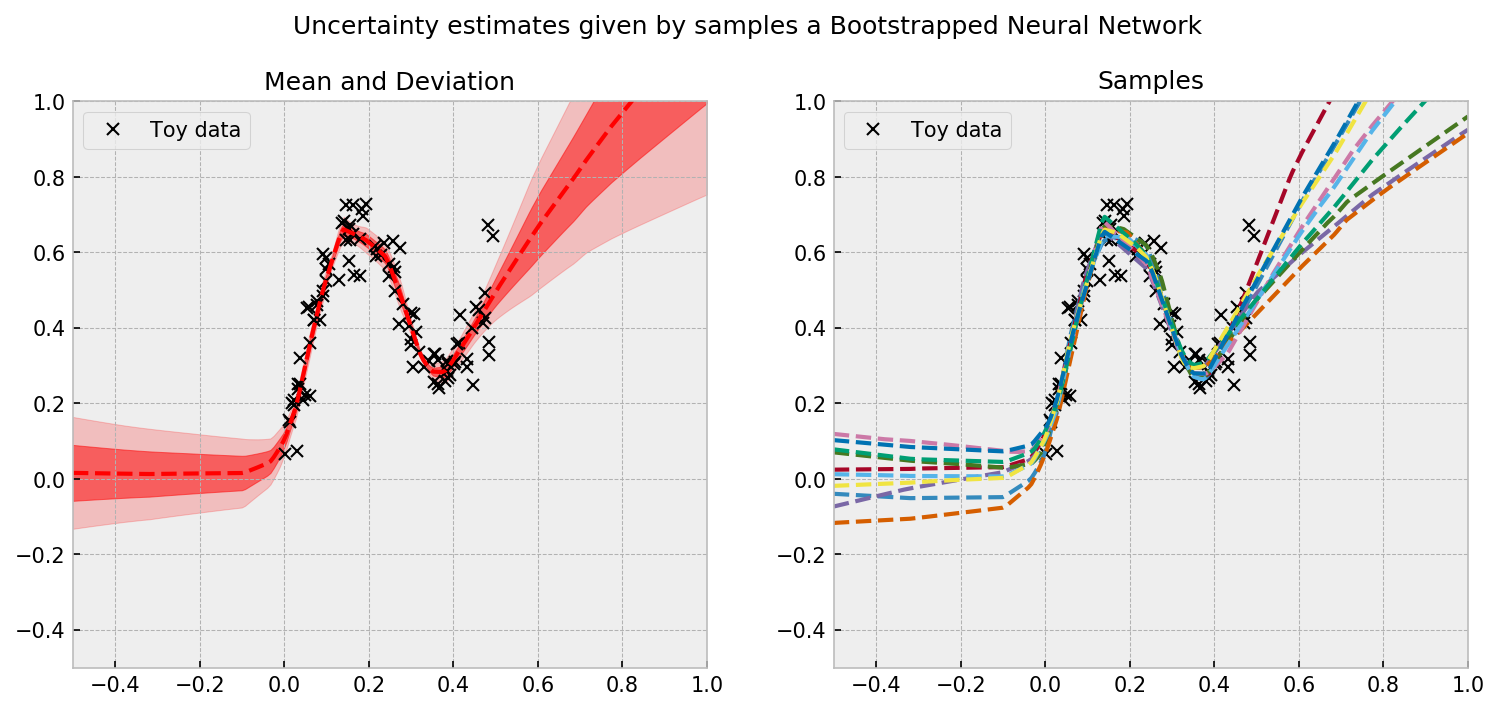

In [14]:
# computing mean and stddev
mean = np.array(y_grid).reshape(10, 200).T.mean(axis=1)
std = np.array(y_grid).reshape(10, 200).T.std(axis=1)

# opening figure
fig = plt.figure(figsize=[12,5], dpi=150)

# title of the plot
fig.suptitle('Uncertainty estimates given by samples a Bootstrapped Neural Network', verticalalignment='center')

# first subplot, 
plt.subplot(1, 2, 1)

# let us plot the training data
plt.plot(x, y, 'kx',  label='Toy data')
plt.title('Mean and Deviation', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-0.5, 1.0)
plt.legend()

# plotting predictive mean and deviation
plt.plot(x_grid, mean, 'r--')
plt.fill_between(x_grid.reshape(1,-1)[0], mean - std, mean + std, alpha=0.5, color='red')
plt.fill_between(x_grid.reshape(1,-1)[0], mean + 2*std, mean - 2*std, alpha=0.2, color='red')

# second subplot
plt.subplot(1, 2, 2)

# let us plot the training data
plt.plot(x, y, 'kx', label='Toy data')
plt.title('Samples', fontsize=12)
plt.xlim(-0.5, 1.0); plt.ylim(-0.5, 1.0)
plt.legend()

# loop for plotting predictions of each head 
for i in range(N_HEADS):
    plt.plot(x_grid, y_grid[i], linestyle='--')
    
# showing
plt.show();

**Great!!!** We can see a reasonable uncertainty estimate given by the individual predictions of the bootstrapped heads. Let us try now to use this architecture to solve the mushroom bandit problem.

## Data

Let us get our data. We will use the Mushroom dataset from UCI.

##### Reading the data and doing minor preprocessing

In [15]:
# reading the dataset
df = pd.read_csv('data/mushroom.csv')

In [16]:
# randomizing the dataset
df = df.sample(frac=1.0)

In [17]:
# let us check the class distribution
df['edible'].value_counts()

e    4208
p    3916
Name: edible, dtype: int64

In [18]:
# let us check the data
df.head()

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3526,e,f,f,n,t,n,f,c,b,p,...,s,g,g,p,w,o,p,n,y,d
3698,e,f,y,g,t,n,f,c,b,n,...,s,w,g,p,w,o,p,n,y,d
273,e,x,y,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,m
3581,p,x,f,g,f,f,f,c,b,g,...,k,b,b,p,w,o,l,h,v,g
5398,p,b,f,n,f,n,f,c,n,w,...,y,w,y,p,w,o,e,w,v,d


##### Now processing the data for training, splitting our dataframe into design matrix and target variable

In [19]:
# splitting our df
X = df.copy().drop('edible', axis=1)
y = df.copy()['edible'].astype('category').cat.codes

In [20]:
# getting dummies for the data
X = pd.get_dummies(X, drop_first=True)

In [21]:
# observing the data
X.head()

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
3526,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3698,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
273,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3581,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5398,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Playing the Mushroom bandit

Let us play the Mushroom bandit with our models. Let us first implement the game.

### The Mushroom bandit game

Let us implement a class which will allow us to play the Mushroom bandit. Let us set up the game as follows:

1. At each round, the agent is presented with all the mushrooms which were not alreaady eaten.
2. The agent ranks the mushrooms, with the most edible mushroom at the top.
3. The agent eats the top $k$ mushrooms and receives feedback.

In [22]:
# coding a class for this
class MushroomBandit:
    
    # initializing
    def __init__(self, X, y):
        
        # storing the initialization
        self.X = X; self.y = y
        
        # let us keep eaten and not eaten mushrooms as well
        self.X_not_eaten = X.copy()
        self.y_not_eaten = y.copy()
        self.X_eaten = pd.DataFrame()
        self.y_eaten = pd.Series()
        
    # function to show not eaten mushrooms
    def get_not_eaten(self):
        return self.X_not_eaten
    
    # function to show eaten mushrrooms
    def get_eaten(self):
        return self.X_eaten, self.y_eaten
    
    # function to get which mushrooms will be eaten
    def eat_mushrooms(self, mushroom_idx):
        
        # get feedback
        feedback = self.y_not_eaten.loc[mushroom_idx].copy()
        
        # remove eaten mushrooms from not eaten dataset
        self.X_not_eaten = self.X_not_eaten.drop(mushroom_idx)
        self.y_not_eaten = self.y_not_eaten.drop(mushroom_idx)
        
        # add eaten mushrooms from eaten dataset
        self.X_eaten = pd.concat([self.X_eaten, self.X.loc[mushroom_idx]])
        self.y_eaten = pd.concat([self.y_eaten, self.y.loc[mushroom_idx]])
        
        # return feedback
        return feedback

### Random Policy

Let us test the game with a random policy!

In [23]:
# number of mushrooms eaten per round
K = 100

# instance of the game
mb = MushroomBandit(X, y)

In [24]:
# we initialize the game by eating the first 50 mushrooms of the base
round_feedback = mb.eat_mushrooms(mb.get_not_eaten().head(50).index)

# and we get the number of rounds
n_rounds = int(mb.get_not_eaten().shape[0]/K) + 1

In [25]:
# list and to accumulate rewards
cum_rewards = 0
cum_rewards_list_random = []

# then, we play until no mushrooms are left
for round_id in tqdm(range(n_rounds)):
    
    # choosing random mushrooms
    to_eat = np.random.choice(mb.get_not_eaten().index, K)
    
    # eating
    feedback = mb.eat_mushrooms(to_eat)
    
    # saving cumulative rewards
    cum_rewards += feedback.sum()
    cum_rewards_list_random.append(cum_rewards)

100%|██████████| 81/81 [00:00<00:00, 135.35it/s]


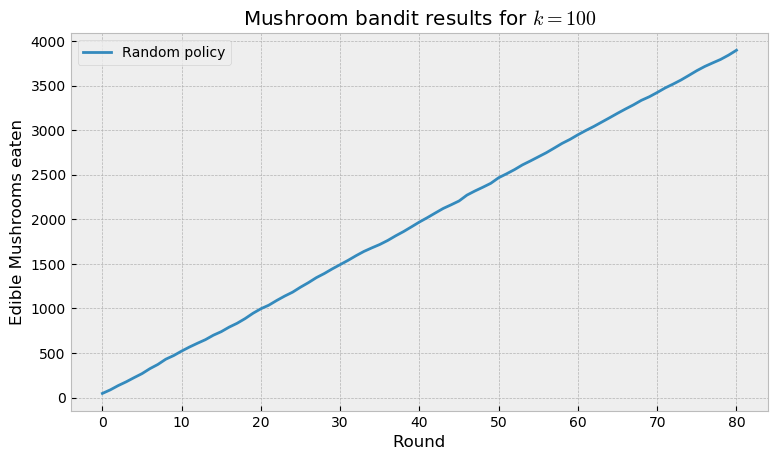

In [26]:
# let us plot the rewards
plt.figure(figsize=[9,5], dpi=100);
plt.plot(cum_rewards_list_random, label='Random policy')
plt.title('Mushroom bandit results for $k = {}$'.format(K))
plt.ylabel('Edible Mushrooms eaten');
plt.xlabel('Round')
plt.legend()
plt.show()

### Greedy Neural Network

Let us play the game with a vanilla neural net. This is equivalent to  agreedy policy, as we eat the mushrooms with the largest expected edible probability. We do not take uncertainty into account.

##### First, let us define the network's architecture

In [27]:
# function to compile a vanilla nn
def get_vanilla_nn():

    # input layer
    input_layer = Input(shape=(X.shape[1],))

    # shared layer
    shared_net = Sequential([Dense(16, activation='relu', input_dim=X.shape[1]),
                             Dropout(0.5),
                             Dense(16, activation='relu'),
                             Dropout(0.5),
                             Dense(16, activation='relu')])

    # connecting the graph to input layer
    input_plus_shared = shared_net(input_layer)

    # output layer
    output_layer = Dense(1, activation='sigmoid')

    # connecting the graph to the rest of the model
    model = output_layer(input_plus_shared)

    # instantiating final model 
    model = Model(inputs=[input_layer], outputs=[model])

    # compiling
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    # returning the model
    return model

##### Now, let's play the game!

In [28]:
# number of mushrooms eaten per round
K = 100

# instance of the game
mb = MushroomBandit(X, y)

In [29]:
# we initialize the game by eating the first 50 mushrooms of the base
round_feedback = mb.eat_mushrooms(mb.get_not_eaten().head(50).index)

# and we get the number of rounds
n_rounds = int(mb.get_not_eaten().shape[0]/K) + 1

In [30]:
# list and to accumulate rewards
cum_rewards = 0
cum_rewards_list_greedy_nn = []

# then, we play until no mushrooms are left
for round_id in tqdm(range(n_rounds)):
    
    # getting our training data
    X_train, y_train = mb.get_eaten()
    
    # getting our model
    model = get_vanilla_nn()
    
    # training
    model.fit(X_train.values, y_train.values, epochs=10, batch_size=32, verbose=0)
    
    # getting our test data
    X_test = mb.get_not_eaten()
    
    # predicting probabilities
    probs = model.predict(X_test)
    
    # choosing random mushrooms
    to_eat = pd.Series(probs[:,0], index=X_test.index).sort_values(ascending=False).head(K).index
    
    # eating
    feedback = mb.eat_mushrooms(to_eat)
    
    # saving cumulative rewards
    cum_rewards += feedback.sum()
    cum_rewards_list_greedy_nn.append(cum_rewards)

100%|██████████| 81/81 [07:32<00:00,  5.59s/it]


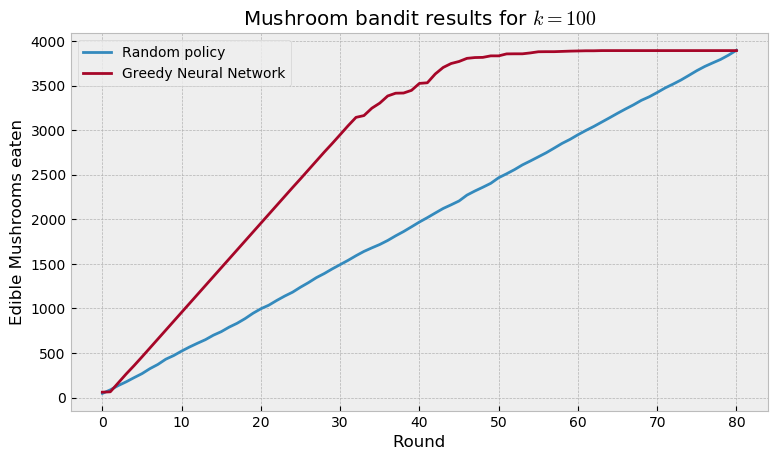

In [31]:
# let us plot the rewards
plt.figure(figsize=[9,5], dpi=100);
plt.plot(cum_rewards_list_random, label='Random policy')
plt.plot(cum_rewards_list_greedy_nn, label='Greedy Neural Network')
plt.title('Mushroom bandit results for $k = {}$'.format(K))
plt.ylabel('Edible Mushrooms eaten');
plt.xlabel('Round')
plt.legend()
plt.show()

### Bootstrapped Neural Network

Let us now use our bootstrapped neural network. We hope that it will explore more and thus learn faster.

##### Building the model, implementing its individual heads

In [32]:
# function for defining the model 
def get_bootstrapped_nn(X_train, y_train):

    # bootstrap rate and number of heads
    BOOTSTRAP_RATE = 1.00
    N_HEADS = 10
    
    # shared layer
    shared_net = Sequential([Dense(16, activation='relu', input_dim=X.shape[1]),
                             Dropout(0.5),
                             Dense(16, activation='relu'),
                             Dropout(0.5)])
    # initializing lists 
    inputs = []
    heads = []
    x_btrap = []
    y_btrap = []

    # loop for creating heads and sampled data points
    for i in range(N_HEADS):

        # deciding sample of data points
        sample_idx = np.random.choice(range(X_train.shape[0]), int(X_train.shape[0]*BOOTSTRAP_RATE), True)

        # defining the heads in the graph
        input_temp = Input(shape=(X_train.shape[1],))
        shared_temp = shared_net(input_temp)
        head_temp = Dense(16, activation='relu')(shared_temp)
        heads.append(Dense(1, activation='sigmoid')(head_temp))
        inputs.append(input_temp)

        # defining data
        x_btrap.append(X_train.iloc[sample_idx])
        y_btrap.append(y_train.iloc[sample_idx])

    # defining the model and plotting it
    model = Model(inputs=inputs, outputs=heads)
    plot_model(model)

    # compiling it
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    # returning the model
    return model, x_btrap, y_btrap

##### Playing the game!

In [33]:
# number of mushrooms eaten per round
K = 100

# instance of the game
mb = MushroomBandit(X, y)

In [34]:
# we initialize the game by eating the first 50 mushrooms of the base
round_feedback = mb.eat_mushrooms(mb.get_not_eaten().head(50).index)

# and we get the number of rounds
n_rounds = int(mb.get_not_eaten().shape[0]/K) + 1

In [36]:
# list and to accumulate rewards
cum_rewards = 0
cum_rewards_list_bnn = []

# then, we play until no mushrooms are left
for round_id in tqdm(range(n_rounds)):
    
    # getting our training data
    X_train, y_train = mb.get_eaten()
    
    # getting the model
    model, x_btrap, y_btrap= get_bootstrapped_nn(X_train, y_train)
    
    # training
    model.fit(x_btrap, y_btrap, epochs=10, batch_size=32, verbose=0)
    
    # getting our test data
    X_test = mb.get_not_eaten()
    
    # predicting probabilities
    probs = np.array(model.predict([X_test] * 10))
    
    # choosing random head
    head_id = np.random.choice(range(10), 1)[0]
    
    # choosing random mushrooms
    to_eat = pd.Series(probs[head_id,:,0], index=X_test.index).sort_values(ascending=False).head(K).index
    
    # eating
    feedback = mb.eat_mushrooms(to_eat)
    
    # saving cumulative rewards
    cum_rewards += feedback.sum()
    cum_rewards_list_bnn.append(cum_rewards)

100%|██████████| 81/81 [1:01:23<00:00, 45.47s/it]


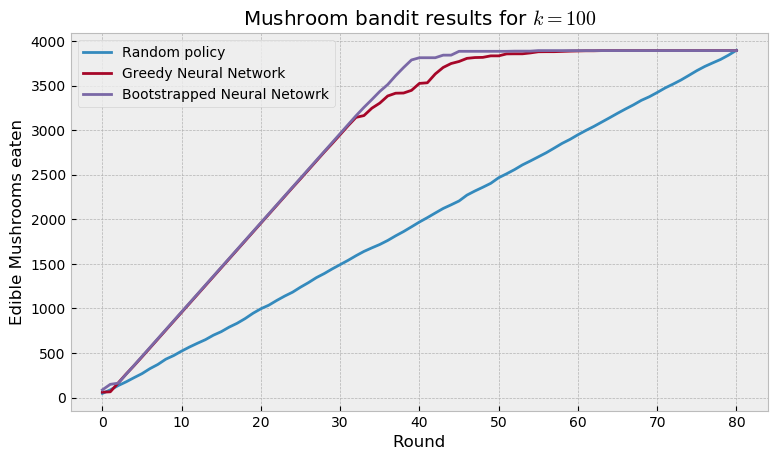

In [37]:
# let us plot the rewards
plt.figure(figsize=[9,5], dpi=100);
plt.plot(cum_rewards_list_random, label='Random policy')
plt.plot(cum_rewards_list_greedy_nn, label='Greedy Neural Network')
plt.plot(cum_rewards_list_bnn, label='Bootstrapped Neural Netowrk')
plt.title('Mushroom bandit results for $k = {}$'.format(K))
plt.ylabel('Edible Mushrooms eaten');
plt.xlabel('Round')
plt.legend()
plt.show()

### Greedy Random Forest

Let us play the game with a greedy Random Forest as well. 

##### As the model is already implemented in sklearn, we can go directly to playing the game

In [38]:
# number of mushrooms eaten per round
K = 100

# instance of the game
mb = MushroomBandit(X, y)

In [39]:
# we initialize the game by eating the first 50 mushrooms of the base
round_feedback = mb.eat_mushrooms(mb.get_not_eaten().head(50).index)

# and we get the number of rounds
n_rounds = int(mb.get_not_eaten().shape[0]/K) + 1

In [40]:
# list and to accumulate rewards
cum_rewards = 0
cum_rewards_list_greedy_rf = []

# then, we play until no mushrooms are left
for round_id in tqdm(range(n_rounds)):
    
    # getting our training data
    X_train, y_train = mb.get_eaten()
    
    # getting our model
    model = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=2)
    
    # training
    model.fit(X_train, y_train)
    
    # getting our test data
    X_test = mb.get_not_eaten()
    
    # predicting probabilities
    probs = model.predict_proba(X_test)
    
    # choosing random mushrooms
    to_eat = pd.Series(probs[:,1], index=X_test.index).sort_values(ascending=False).head(K).index
    
    # eating
    feedback = mb.eat_mushrooms(to_eat)
    
    # saving cumulative rewards
    cum_rewards += feedback.sum()
    cum_rewards_list_greedy_rf.append(cum_rewards)

100%|██████████| 81/81 [00:33<00:00,  2.43it/s]


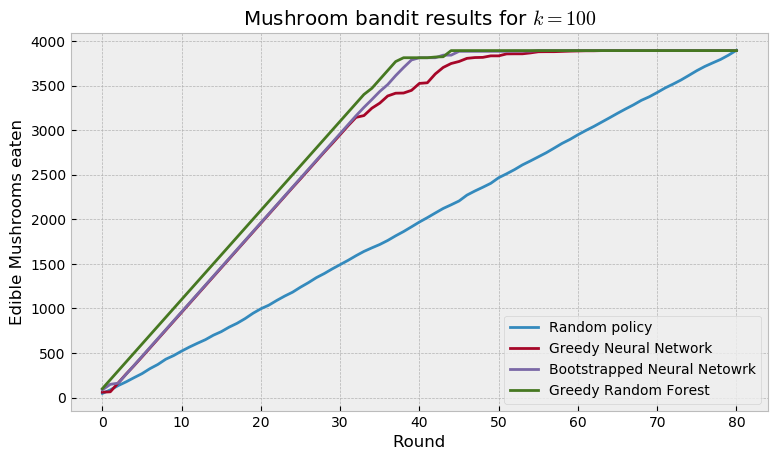

In [41]:
# let us plot the rewards
plt.figure(figsize=[9,5], dpi=100);
plt.plot(cum_rewards_list_random, label='Random policy')
plt.plot(cum_rewards_list_greedy_nn, label='Greedy Neural Network')
plt.plot(cum_rewards_list_bnn, label='Bootstrapped Neural Netowrk')
plt.plot(cum_rewards_list_greedy_rf, label='Greedy Random Forest')
plt.title('Mushroom bandit results for $k = {}$'.format(K))
plt.ylabel('Edible Mushrooms eaten');
plt.xlabel('Round')
plt.legend()
plt.show()

### Sampled Random Forest

Let us check if the Random Forest Sampling strategy shows good results in this case.

##### As the model is already implemented in sklearn, we can go directly to playing the game

In [56]:
# number of mushrooms eaten per round
K = 100

# instance of the game
mb = MushroomBandit(X, y)

In [57]:
# we initialize the game by eating the first 50 mushrooms of the base
round_feedback = mb.eat_mushrooms(mb.get_not_eaten().head(50).index)

# and we get the number of rounds
n_rounds = int(mb.get_not_eaten().shape[0]/K) + 1

In [58]:
# list and to accumulate rewards
cum_rewards = 0
cum_rewards_list_sampled_rf = []

# then, we play until no mushrooms are left
for round_id in tqdm(range(n_rounds)):
    
    # getting our training data
    X_train, y_train = mb.get_eaten()
    
    # getting our model
    model = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=2)
    
    # training
    model.fit(X_train, y_train)
    
    # getting our test data
    X_test = mb.get_not_eaten()
    
    # predicting probabilities, four trees at a time
    probs = np.array([e.predict_proba(X_test)[:,1] for e in np.random.choice(model.estimators_, 4)]).mean(axis=0)
    
    # choosing random mushrooms
    to_eat = pd.Series(probs, index=X_test.index).sort_values(ascending=False).head(K).index
    
    # eating
    feedback = mb.eat_mushrooms(to_eat)
    
    # saving cumulative rewards
    cum_rewards += feedback.sum()
    cum_rewards_list_sampled_rf.append(cum_rewards)

100%|██████████| 81/81 [00:29<00:00,  2.76it/s]


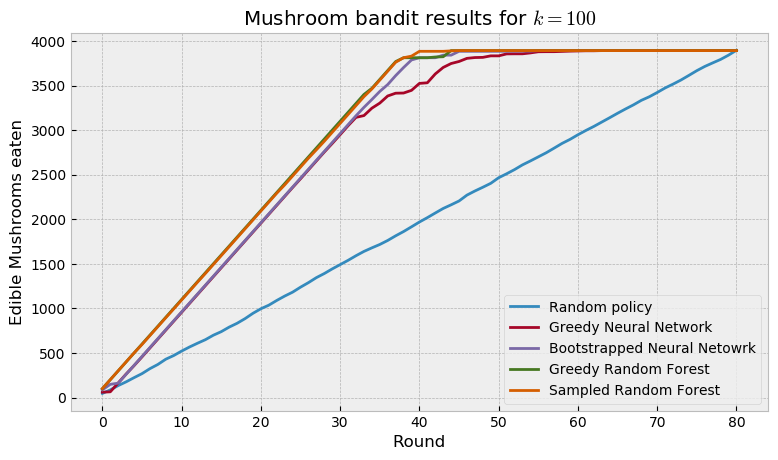

In [59]:
# let us plot the rewards
plt.figure(figsize=[9,5], dpi=100);
plt.plot(cum_rewards_list_random, label='Random policy')
plt.plot(cum_rewards_list_greedy_nn, label='Greedy Neural Network')
plt.plot(cum_rewards_list_bnn, label='Bootstrapped Neural Netowrk')
plt.plot(cum_rewards_list_greedy_rf, label='Greedy Random Forest')
plt.plot(cum_rewards_list_sampled_rf, label='Sampled Random Forest')
plt.title('Mushroom bandit results for $k = {}$'.format(K))
plt.ylabel('Edible Mushrooms eaten');
plt.xlabel('Round')
plt.legend()
plt.show()

## Conclusion

Even that this dataset is fairly easy for the models, we can check that randomizing decisions offer improvements over greedy decisions. On the final plot the randomized models outperformed the greedy models, especially on the hardest mushrooms (the last ones to be eaten). On this particular case, Random Forest compared favourably against neural networks, and are trained and sampled in a fraction of the time.

In the future, we should try out other methods like UCB and $\epsilon$-greedy, expecting that they will be outperformed by Thompson Sampling, as recent research suggests.